# Quasi-Supervised Learning. Use VQSR's labels as training labels for supervised models

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import time
from math import sqrt
from sklearn.externals import joblib
from os.path import join

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/nicochaves/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nicochaves/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

### Set Relevant Paths

In [4]:
data_dir = '../../data'
saved_models_dir = 'saved_models'

## Load Data (No need for train/test split since we don't use test set info for training)

In [5]:
chr11_dir = join(data_dir,'processed/chrom11')
chr11_file = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.11.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels.table'
df_full = pd.read_csv(join(chr11_dir, chr11_file), sep='\t')

'''file_dir = '../data/processed/chrom20/'
filename = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels'
train_file = file_dir + filename + '.train.table'
test_file = file_dir + filename + '.test.table'

df_train_full = pd.read_csv(train_file, sep='\t') # training and dev sets combined
df_test = pd.read_csv(test_file, sep='\t')
'''


"file_dir = '../data/processed/chrom20/'\nfilename = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels'\ntrain_file = file_dir + filename + '.train.table'\ntest_file = file_dir + filename + '.test.table'\n\ndf_train_full = pd.read_csv(train_file, sep='\t') # training and dev sets combined\ndf_test = pd.read_csv(test_file, sep='\t')\n"

In [6]:
print 'Features (some of these may get taken out): ', df_full.columns
print '# of examples: ', df_full.shape[0]

Features (some of these may get taken out):  Index([u'Unnamed: 0', u'QUAL', u'AC', u'AF', u'DP', u'FS', u'MLEAC', u'MLEAF',
       u'MQ', u'QD', u'SOR', u'sample1.DP', u'sample1.GQ',
       u'POSITIVE_TRAIN_SITE', u'DB', u'FILTER', u'GROUND_TRUTH'],
      dtype='object')
# of examples:  187242


In [7]:
df_full = df_full.drop(['Unnamed: 0'], axis=1)  

## Split data into X and Y

In [9]:
df_Y = df_full['GROUND_TRUTH']
df_Y_quasi = df_full['POSITIVE_TRAIN_SITE']
df_X = df_full.drop(['GROUND_TRUTH', 'POSITIVE_TRAIN_SITE'], axis=1)

# Evaluate VQSR Performance

In [10]:
# See https://software.broadinstitute.org/gatk/guide/article?id=39 for interpretation of tranche labels

LOW_QUAL = 'LowQual'
TRANCHE_99_9 = 'VQSRTrancheSNP99.90to100.00' # if you ignore these and the above, you recover at most 99.9% of all variants. has some low vqslod values
TRANCHE_99 = 'VQSRTrancheSNP99.00to99.90' # if you retain these and ignore the above, you'll recover at most 99% of variants. 
PASS_ALL = 'PASS'  # if you **retain** these and ignore the above, you'll recover at most 90% of the variants

def did_variant_pass_filter(label, tranche):
    return label == PASS_ALL or \
            (tranche == TRANCHE_99 and label == TRANCHE_99) or \
            (tranche == TRANCHE_99_9 and (label == TRANCHE_99 or label == TRANCHE_99_9))
            
def convert_vqsr_labels(raw_labels, tranche=None):
    num_labels = raw_labels.shape[0]
    labels = num_labels * [0]
    for i, label in enumerate(raw_labels):
        if did_variant_pass_filter(label, tranche):
            labels[i] = 1
    return labels        

In [12]:
vqsr_labels = df_X['FILTER']
vqsr_tranches_uniq = set(df_X['FILTER'])

if LOW_QUAL in vqsr_tranches_uniq:
    vqsr_tranches_uniq -= {LOW_QUAL}

vqsr_tranches_uniq = list(vqsr_tranches_uniq)    

vqsr_prec = np.zeros(len(vqsr_tranches_uniq))
vqsr_recall = np.zeros(len(vqsr_tranches_uniq))
vqsr_f1 = np.zeros(len(vqsr_tranches_uniq))

for i, tranche in enumerate(vqsr_tranches_uniq):
    print 'Tranche: ', tranche

    vqsr_labels_binary = convert_vqsr_labels(vqsr_labels, tranche)
    vqsr_acc = accuracy_score(df_Y, vqsr_labels_binary)
    print 'VQSR Test Accuracy: ', vqsr_acc
    
    vqsr_prec[i] = precision_score(df_Y, vqsr_labels_binary)
    vqsr_recall[i] = recall_score(df_Y, vqsr_labels_binary)
    print 'Precision: ', vqsr_prec[i]
    print 'Recall: ', vqsr_recall[i]
    
    
    vqsr_f1[i] = f1_score(df_Y, vqsr_labels_binary, average='weighted')  
    print 'F1 score: ', vqsr_f1[i]

Tranche:  VQSRTrancheSNP99.00to99.90
VQSR Test Accuracy:  0.923484047383
Precision:  0.962087570751
Recall:  0.955792517415
F1 score:  0.925066751711
Tranche:  VQSRTrancheSNP99.90to100.00
VQSR Test Accuracy:  0.929908887963
Precision:  0.940548573046
Recall:  0.987416639523
F1 score:  0.911392264577
Tranche:  PASS
VQSR Test Accuracy:  0.885917689407
Precision:  0.972859341336
Recall:  0.903127553674
F1 score:  0.903112976402


## Remove VQSR Filter label so that we can run non-VQSR methods

In [14]:
df_X = df_X.drop(['FILTER'], axis=1)

# Quasi Supervised Learning Approaches

In [18]:
# Number of folds for cross validation
num_folds = 5

# Loss function to use. Must be either 'l1' or 'l2'
loss_function = 'l2'  

In [21]:
def f1_prec_recall(pred, labels, verbose=True):
    f1 = f1_score(pred, labels, average='binary')
    prec = precision_score(pred, labels)
    recall = recall_score(pred, labels)
    
    if verbose:
        # Make a Pandas DataFrame to print results more nicely
        df = pd.DataFrame(data=np.asarray([[f1, prec, recall]]),
                         columns=['F1', 'Precision', 'Recall'])
        print df.to_string(index=False, justify='left')
        
    return f1, prec, recall

## Logistic Regression

In [20]:
lr_start = time.clock()

lr_params = {'C':np.logspace(-1, 7, 20)}
lr_obj = linear_model.LogisticRegression(penalty=loss_function, random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
lr_classifier = GridSearchCV(lr_obj, lr_params, cv=num_folds, scoring='f1')
lr_classifier.fit(df_X, df_Y_quasi)

lr_stop = time.clock()
lr_time_train = lr_stop - lr_start

print 'Logistic Regression CV Time (in seconds): ', lr_time_train

Logistic Regression CV Time (in seconds):  237.725774


In [25]:
# Save the classifier
joblib.dump(lr_classifier, join(saved_models_dir,'lr_classifier'))

['saved_models/lr_classifier']

In [ ]:
# Load the saved classifier
lr_classifier = joblib.load(join(saved_models_dir,'lr_classifier'))

In [26]:
print 'Logistic Regression Best Estimator: ', lr_classifier.best_estimator_

Logistic Regression Best Estimator:  LogisticRegression(C=78475.997035146065, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


## Support Vector Classifier (consider running this if you can get better performance for the non-quasi approach. otherwise SVC just takes too long to justify running it)

## Random Forest Classifier

In [29]:
num_features = df_X.shape[1]

rf_start = time.clock()

# Use 20 trees in the forest (if you have the time or resources, consider using more trees)
# However, I've tried up to 50 trees and it makes very little difference on dev set error
rf_params = {"n_estimators":[20], 
             "criterion": ["gini", "entropy"], 
             "max_features": range(int(sqrt(num_features)), num_features, 2)
            }
rf_obj = RandomForestClassifier(random_state=0)

rf_classifier = GridSearchCV(rf_obj, rf_params, cv=num_folds, scoring='f1')
rf_classifier.fit(df_X, df_Y_quasi)

rf_stop = time.clock()
rf_time_train = rf_stop - rf_start

print 'Random Forest CV Time (in seconds): ', rf_time_train

Random Forest CV Time (in seconds):  579.565423


In [30]:
# Save the classifier
joblib.dump(rf_classifier, join(saved_models_dir,'rf_classifier'))

['saved_models/rf_classifier']

In [ ]:
rf_classifier = joblib.load(join(saved_models_dir,'rf_classifier'))

In [31]:
print 'Rand Forest Best Estimator: ', rf_classifier.best_estimator_

Rand Forest Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


# Evaluate classifiers using the ground truth labels.

## Logistic Regression

In [28]:
lr_start = time.clock()

lr_pred_test = lr_classifier.predict(df_X)

lr_stop = time.clock()
lr_time_test = lr_stop - lr_start
print 'Execution Time (in seconds): ', lr_time_test

lr_f1, lr_prec, lr_recall = f1_prec_recall(df_Y, lr_pred_test)  

Execution Time (in seconds):  0.022191
F1        Precision  Recall 
0.947431  0.966241   0.92934


## SVC

## Random Forest

In [32]:
rf_start = time.clock()

rf_pred_test = rf_classifier.predict(df_X)

rf_stop = time.clock()
rf_time_test = rf_stop - rf_start
print 'Execution Time (in seconds): ', rf_time_test

rf_f1, rf_prec, rf_recall = f1_prec_recall(df_Y, rf_pred_test) 

Execution Time (in seconds):  1.207542
F1        Precision  Recall 
0.935569  0.991076   0.88595


# Plot the Results

In [33]:
methods = ['VQSR (99%)', 'VQSR (99.9%)', 'Logisitc Reg', 'Rand Forest']
colors = ['c', 'b', 'r', 'g']
vqsr_tranche_idx_99 = vqsr_tranches_uniq.index(PASS_ALL)
vqsr_tranche_idx_99_9 = vqsr_tranches_uniq.index(TRANCHE_99)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


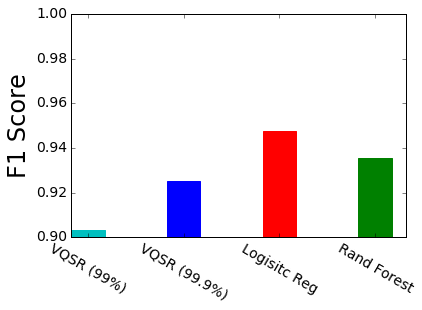

In [34]:
plt.figure()

f1s = [vqsr_f1[vqsr_tranche_idx_99], vqsr_f1[vqsr_tranche_idx_99_9], lr_f1, rf_f1]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, f1s, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('F1 Score', fontsize=24)
plt.show()

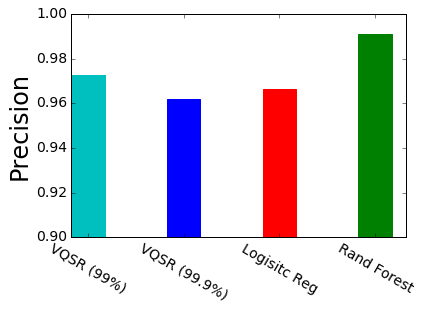

In [35]:
plt.figure()

precs = [vqsr_prec[vqsr_tranche_idx_99], vqsr_prec[vqsr_tranche_idx_99_9], lr_prec, rf_prec]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, precs, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('Precision', fontsize=24)
plt.show()


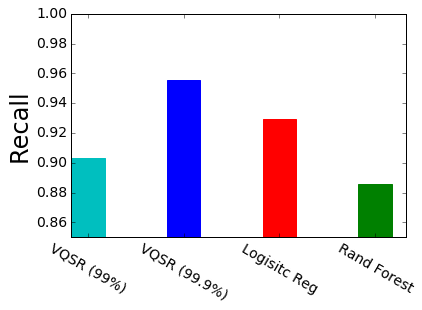

In [37]:
plt.figure()

recalls = [vqsr_recall[vqsr_tranche_idx_99], vqsr_recall[vqsr_tranche_idx_99_9], lr_recall, rf_recall]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, recalls, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.85, 1.0])
plt.ylabel('Recall', fontsize=24)
plt.show()